In [245]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set()

In [246]:
#導入每一張sheet(Import each sheet)
airline = ["IAGl Historical Data.csv","0H4A Historical Data.csv","EZJ Historical Data.csv","JET2 Historical Data.csv"]
company_identifier = ["IAG1","0H4A","EZJ","JET2"]
#建立一個空的列表，為了將迴圈讀取的資料存進來(Create an empty list)
data_frames=[] 

#函數zip用於多個迴圈對象,所以你會有兩個i，我這裡設定一個airline一個company，他們會同時同步針對不同的list進行迴圈(The zip function is used for multiple loop objects)
for airline, company in zip(airline, company_identifier):
    file = pd.read_csv(airline, thousands=",") #讓千分位點變成float型態(Convert the thousands separator into a float type)
    file["Company Identifier"] = company #新增一個欄位company identifier，=的右方會是其新增的col中的值(Add a new column called 'company identifier')
    data_frames.append(file) #將讀取到的file新增進空列表中(Add the read file into the empty list)



#pd.concat可以結合許多數據結構，也可以針對新的數據結構進行一些修正，例如下面comment的排序表現問題(pd.concat concatenates many data structures)
#ignore_index=True要為True，不然索引值永遠都不會有012345的排序展現，可能會一直012012012...
combined_data = pd.concat(data_frames,ignore_index=True)

#修正Date欄位的型態(Correct the data type of the 'Date' column)
combined_data["Date"] = pd.to_datetime(combined_data["Date"], format="%m/%d/%Y")


#刪除不必要的欄位(Delete unnecessary columns)
new_sheet = combined_data.drop(columns=["Open","High","Low","Vol.","Change %"])

print(new_sheet)


          Date   Price Company Identifier
0   2023-09-01  151.15               IAG1
1   2023-08-01  162.12               IAG1
2   2023-07-01  170.88               IAG1
3   2023-06-01  161.90               IAG1
4   2023-05-01  154.25               IAG1
..         ...     ...                ...
444 2014-05-01  276.00               JET2
445 2014-04-01  294.50               JET2
446 2014-03-01  278.50               JET2
447 2014-02-01  286.75               JET2
448 2014-01-01  255.50               JET2

[449 rows x 3 columns]


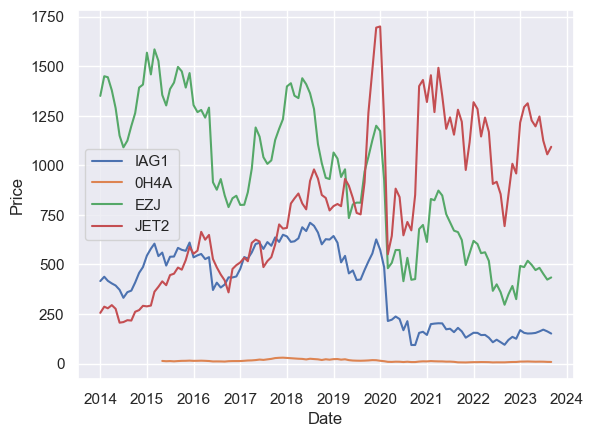

In [247]:
sns.lineplot(data=new_sheet, x='Date', y='Price',hue="Company Identifier",legend="auto") #hue讓圖根據四條線自行分類(Using 'hue' allows the plot to categorize itself based on four lines)

legend = plt.legend()

In [249]:
#find out the NaN value and delete it

pivot = pd.pivot_table(new_sheet, index='Date', columns='Company Identifier', values='Price') #create pivot table
pivot_cleaned = pivot.dropna(how='any') #delete the NaN value #參數用法：當行或列中包含任何NaN值，則刪除該行或列
print(pivot_cleaned)


Company Identifier   0H4A      EZJ    IAG1    JET2
Date                                              
2015-05-01          12.98  1354.64  559.49   414.5
2015-06-01          11.56  1301.60  493.96   395.0
2015-07-01          12.35  1384.10  538.53   446.0
2015-08-01          11.03  1416.94  539.53   453.0
2015-09-01          12.43  1496.08  583.24   484.0
...                   ...      ...     ...     ...
2023-05-01           9.12   471.30  154.25  1196.0
2023-06-01           9.41   482.60  161.90  1246.0
2023-07-01           9.21   452.30  170.88  1124.0
2023-08-01           8.27   423.20  162.12  1055.0
2023-09-01           7.97   434.10  151.15  1093.0

[98 rows x 4 columns]


In [250]:
#adjust the format to the original dataframe format
new_sheet = pivot_cleaned.stack().reset_index(name='Price') 
#stack用於轉換格式 #reset_index用於將索引列重設為默認整數索引
#而name="Price"則是要讓原本在樞紐表格中成為值的price重新變回一欄並給其名稱



print(new_sheet)



          Date Company Identifier    Price
0   2015-05-01               0H4A    12.98
1   2015-05-01                EZJ  1354.64
2   2015-05-01               IAG1   559.49
3   2015-05-01               JET2   414.50
4   2015-06-01               0H4A    11.56
..         ...                ...      ...
387 2023-08-01               JET2  1055.00
388 2023-09-01               0H4A     7.97
389 2023-09-01                EZJ   434.10
390 2023-09-01               IAG1   151.15
391 2023-09-01               JET2  1093.00

[392 rows x 3 columns]


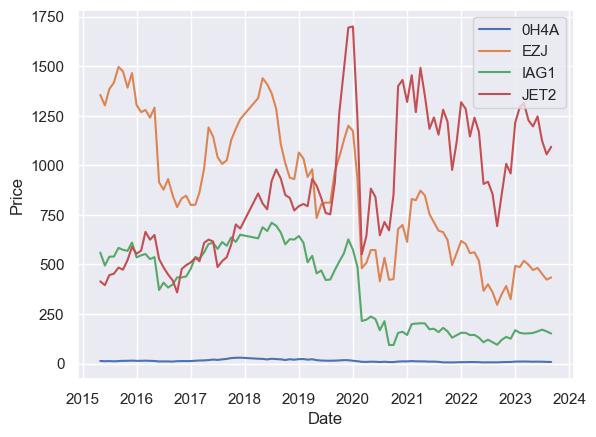

In [251]:
sns.lineplot(data=new_sheet, x='Date', y='Price',hue="Company Identifier",legend="auto")

legend = plt.legend()


__另一個做法 Another method__

#find out the initial prices of every company

prices_0 = new_sheet[new_sheet["Date"]==new_sheet["Date"].min()]

#new_sheet["Date"].min()找出日期列中最小的日期

#會用==是為了要產生一個布林值series

#最開頭的new_sheet[]是為了要訪問並抓取布林值為True的列


prices_0_dict = prices_0.set_index("Company Identifier")["Price"].to_dict()

#設置字典,方便查找用，set_index(放入鍵，有點類似索引)[放入值，可以想成是索引下的目標值，所以通常情況下只會有一個值]

In [252]:
#新增一為Relative Price的欄(Add a column for Relative Price)
new_sheet["Relative Price"] = (new_sheet["Price"] / new_sheet.groupby("Company Identifier")["Price"].transform("first")) * 100
#使用groupby將我的sheet以Company Identifier分組，並在組內對Price進行後續計算
#.transform(),因為填入first,所以只會讀取妹個分組內的第一個price(即初始股價)

print(new_sheet)


          Date Company Identifier    Price  Relative Price
0   2015-05-01               0H4A    12.98      100.000000
1   2015-05-01                EZJ  1354.64      100.000000
2   2015-05-01               IAG1   559.49      100.000000
3   2015-05-01               JET2   414.50      100.000000
4   2015-06-01               0H4A    11.56       89.060092
..         ...                ...      ...             ...
387 2023-08-01               JET2  1055.00      254.523522
388 2023-09-01               0H4A     7.97       61.402157
389 2023-09-01                EZJ   434.10       32.045414
390 2023-09-01               IAG1   151.15       27.015675
391 2023-09-01               JET2  1093.00      263.691194

[392 rows x 4 columns]


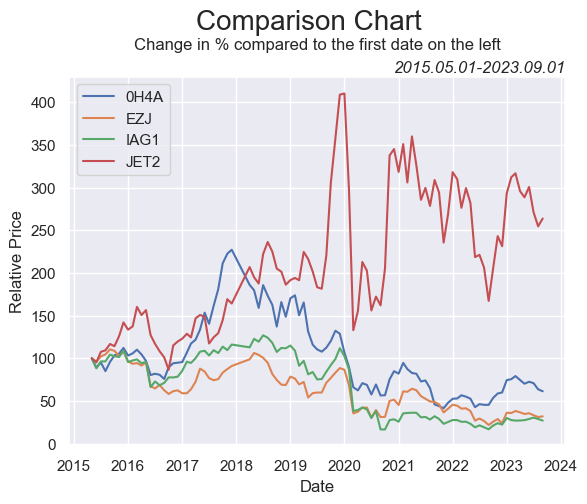

In [321]:
sns.lineplot(data=new_sheet, x='Date', y='Relative Price',hue="Company Identifier",legend="auto")
plt.suptitle("Comparison Chart", fontsize=20, y=1.02)
plt.title("Change in % compared to the first date on the left", y=1.05)
plt.title("2015.05.01-2023.09.01",style = "italic",loc="right",y=0.99)


legend = plt.legend() #顯示圖例
plt.show()

-----------------------

***My personal notes***

***Groupby in Pandas***

1.分組數據：可以根據一個或多個列的值將數據分成不同的組，例如，可以根據Company Identifier列的值分組

2.應用聚合操作：一旦完成分組，可以在每個組上應用聚合函數。這些函數可以對組內的數據執行會總計算，如總和、平均值、計數

3.獲得結果：聚合操作的結果是一個新的DataFrame或Series，其中包含每個組的聚合值。



***apply in Pandas***

apply是pandas中的一中方法，可以做於數學運算、統計計算、文本處理、自訂自函數、數據轉換

data_frame.apply(function, axis)

1.function為要應用的函數，可以是內建、自定義

2.axis指定函數要運用在哪個軸上axis=0 along the rows(上下操作)、axis=1 along the columns(左右操作)

***map in Pandas***

Series.map(arg, na_action=None)

1.arg可以是函數、字典或Series
2.na_action可選參數，用於指定對缺失值(NaN)的處理方式

作業運用map去完成字典映射

__Example__

import pandas as pd

创建一个示例数据集

data = {'Brand': ['Toyota', 'Ford', 'Honda', 'Chevrolet', 'Nissan']}
df = pd.DataFrame(data)

创建一个品牌到国家的映射字典

brand_to_country = {
    'Toyota': 'Japan',
    'Ford': 'USA',
    'Honda': 'Japan',
    'Chevrolet': 'USA',
    'Nissan': 'Japan'
}

使用map方法进行映射


df['Country'] = df['Brand'].map(brand_to_country)

print(df)

--------
輸出

              Brand    Country
       0     Toyota    Japan
       1       Ford      USA
       2      Honda    Japan
       3  Chevrolet      USA
       4     Nissan    Japan